# Time-Aware Neural Network Visualization

This notebook demonstrates how a single time-aware layer responds to:
1. Different input values
2. Same input at different time intervals
3. Temporal memory effects

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.neural.neuron import TimeAwareLinear

# Set style for better visualizations
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## Create Simple Time-Aware Layer (1 input → 1 output)

In [8]:
# Create a simple single neuron (1 input, 1 output)
neuron = TimeAwareLinear(in_features=1, out_features=1, alpha=1.0)

# Set fixed weights for reproducible results
with torch.no_grad():
    neuron.weight.fill_(0.5)  # Weight = 0.5
    neuron.bias.fill_(0.1)    # Bias = 0.1

print(f"Neuron configuration:")
print(f"Weight: {neuron.weight.item():.2f}")
print(f"Bias: {neuron.bias.item():.2f}")
print(f"Alpha (memory strength): {neuron.alpha}")


Neuron configuration:
Weight: 0.50
Bias: 0.10
Alpha (memory strength): 1.0


## Experiment 1: Different Input Values (Fixed Time Intervals)

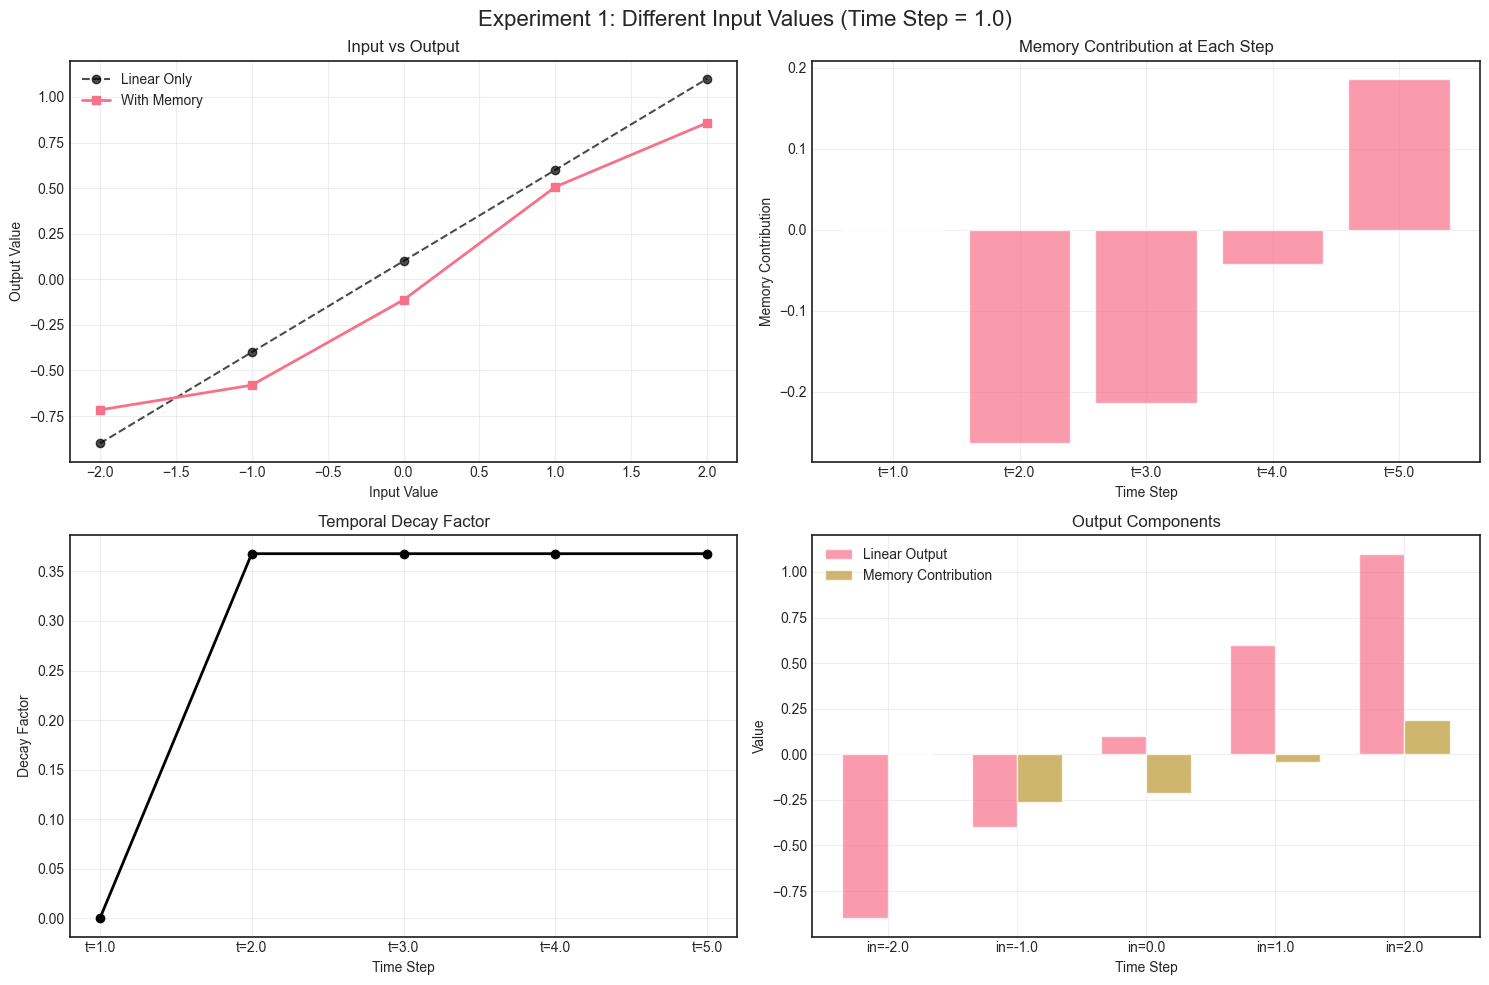


Detailed Results:
Input	Linear	Memory	Decay	Final
---------------------------------------------
 -2.0	-0.900	 0.000	0.000	-0.716
 -1.0	-0.400	-0.264	0.368	-0.581
  0.0	 0.100	-0.214	0.368	-0.113
  1.0	 0.600	-0.042	0.368	 0.507
  2.0	 1.100	 0.186	0.368	 0.858


In [9]:
def experiment_different_inputs():
    neuron.reset_state()
    
    # Test different input values with fixed time step
    inputs = [-2.0, -1.0, 0.0, 1.0, 2.0]
    time_step = 1.0
    
    results = []
    current_time = 0.0
    
    for inp in inputs:
        current_time += time_step
        
        # Get components for visualization
        with torch.no_grad():
            x = torch.tensor(inp)
            
            # Calculate linear output
            linear_out = inp * neuron.weight.item() + neuron.bias.item()
            
            # Calculate memory contribution
            if neuron.initialized:
                time_diff = current_time - neuron.prev_timestamp
                decay = np.exp(-time_diff)
                memory_contrib = neuron.alpha * neuron.prev_values.item() * decay
            else:
                decay = 0.0
                memory_contrib = 0.0
            
            # Get final output
            output = neuron(x, current_time)
            
            results.append({
                'input': inp,
                'time': current_time,
                'linear_out': linear_out,
                'memory_contrib': memory_contrib,
                'raw_total': linear_out + memory_contrib,
                'final_output': output.item(),
                'decay_factor': decay
            })
    
    return results

results1 = experiment_different_inputs()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Experiment 1: Different Input Values (Time Step = 1.0)', fontsize=16)

# Plot 1: Input vs Output
inputs = [r['input'] for r in results1]
outputs = [r['final_output'] for r in results1]
linear_outs = [r['linear_out'] for r in results1]

axes[0,0].plot(inputs, linear_outs, 'o--', label='Linear Only', alpha=0.7, color='black')
axes[0,0].plot(inputs, outputs, 's-', label='With Memory', linewidth=2)
axes[0,0].set_xlabel('Input Value')
axes[0,0].set_ylabel('Output Value')
axes[0,0].set_title('Input vs Output')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Memory Contribution Over Time
times = [r['time'] for r in results1]
memory_contribs = [r['memory_contrib'] for r in results1]
decay_factors = [r['decay_factor'] for r in results1]

axes[0,1].bar(range(len(times)), memory_contribs, alpha=0.7, label='Memory Contribution')
axes[0,1].set_xlabel('Time Step')
axes[0,1].set_ylabel('Memory Contribution')
axes[0,1].set_title('Memory Contribution at Each Step')
axes[0,1].set_xticks(range(len(times)))
axes[0,1].set_xticklabels([f't={t:.1f}' for t in times])
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Decay Factors
axes[1,0].plot(range(len(decay_factors)), decay_factors, 'o-', color='black', linewidth=2)
axes[1,0].set_xlabel('Time Step')
axes[1,0].set_ylabel('Decay Factor')
axes[1,0].set_title('Temporal Decay Factor')
axes[1,0].set_xticks(range(len(times)))
axes[1,0].set_xticklabels([f't={t:.1f}' for t in times])
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Component breakdown
x_pos = np.arange(len(results1))
width = 0.35

axes[1,1].bar(x_pos - width/2, linear_outs, width, label='Linear Output', alpha=0.7)
axes[1,1].bar(x_pos + width/2, memory_contribs, width, label='Memory Contribution', alpha=0.7)
axes[1,1].set_xlabel('Time Step')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Output Components')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels([f'in={inp:.1f}' for inp in inputs])
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed results
print("\nDetailed Results:")
print("Input\tLinear\tMemory\tDecay\tFinal")
print("-" * 45)
for r in results1:
    print(f"{r['input']:5.1f}\t{r['linear_out']:6.3f}\t{r['memory_contrib']:6.3f}\t{r['decay_factor']:5.3f}\t{r['final_output']:6.3f}")

## Experiment 2: Same Input, Different Time Intervals

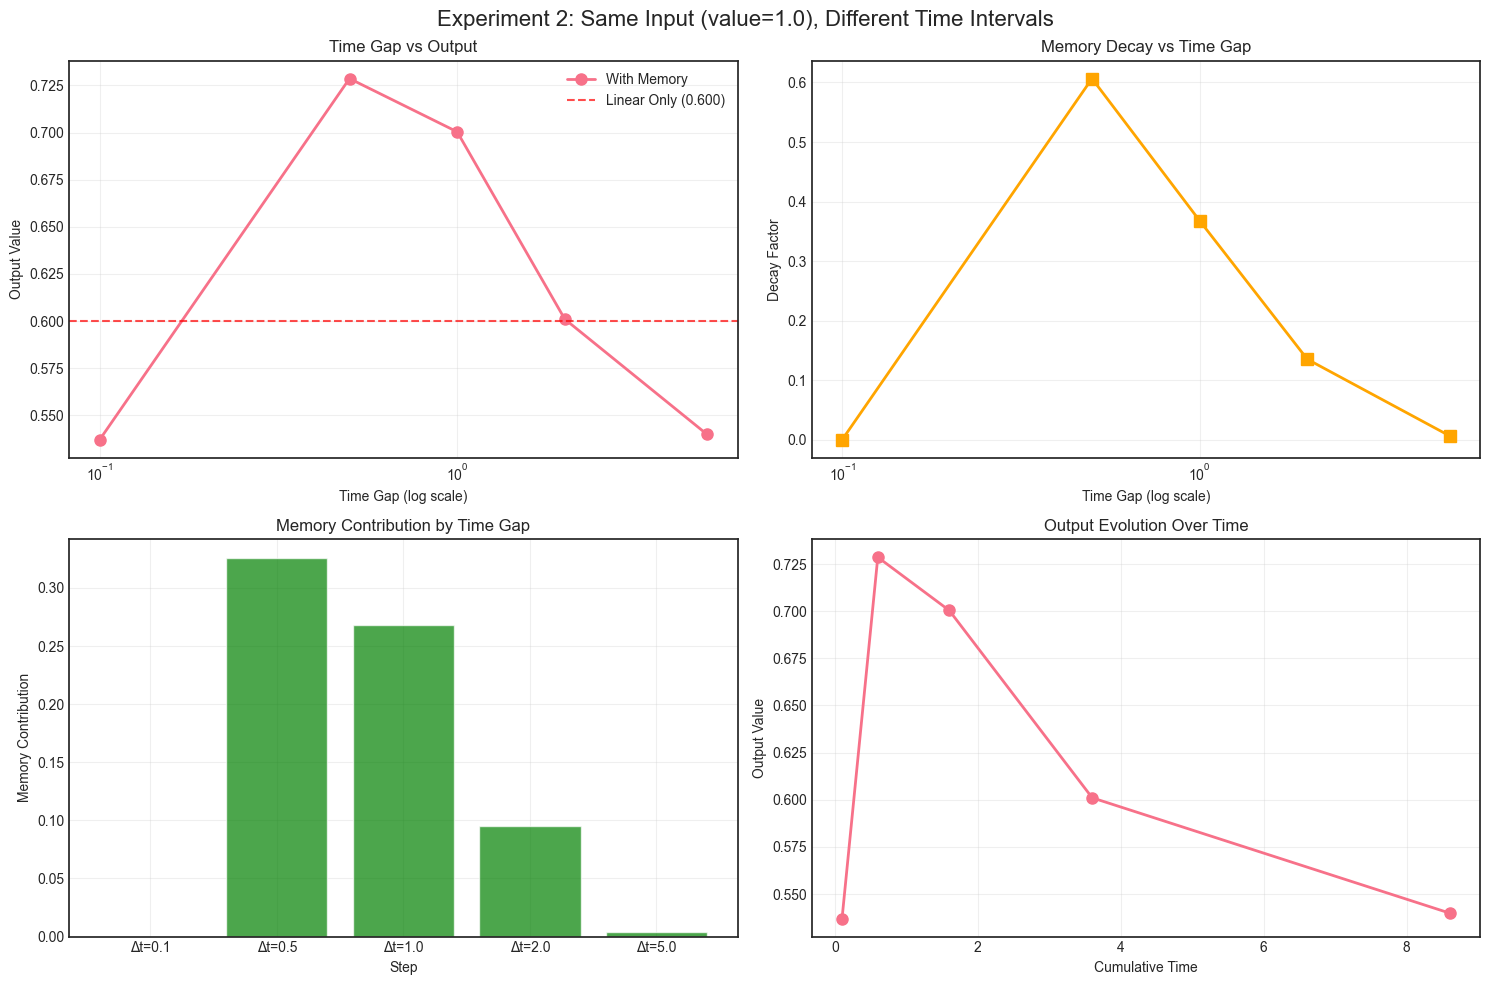


Detailed Results:
TimeGap	CumTime	Decay	Memory	Output
---------------------------------------------
    0.1	    0.1	0.000	 0.000	 0.537
    0.5	    0.6	0.607	 0.326	 0.729
    1.0	    1.6	0.368	 0.268	 0.700
    2.0	    3.6	0.135	 0.095	 0.601
    5.0	    8.6	0.007	 0.004	 0.540


In [10]:
def experiment_different_timing():
    neuron.reset_state()
    
    # Same input value, different time intervals
    input_value = 1.0
    time_intervals = [0.1, 0.5, 1.0, 2.0, 5.0]  # Different time gaps
    
    results = []
    current_time = 0.0
    
    for time_gap in time_intervals:
        current_time += time_gap
        
        with torch.no_grad():
            x = torch.tensor(input_value)
            
            # Calculate components
            linear_out = input_value * neuron.weight.item() + neuron.bias.item()
            
            if neuron.initialized:
                time_diff = current_time - neuron.prev_timestamp
                decay = np.exp(-time_diff)
                memory_contrib = neuron.alpha * neuron.prev_values.item() * decay
            else:
                decay = 0.0
                memory_contrib = 0.0
            
            output = neuron(x, current_time)
            
            results.append({
                'time_gap': time_gap,
                'time': current_time,
                'linear_out': linear_out,
                'memory_contrib': memory_contrib,
                'final_output': output.item(),
                'decay_factor': decay
            })
    
    return results

results2 = experiment_different_timing()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Experiment 2: Same Input (value=1.0), Different Time Intervals', fontsize=16)

# Plot 1: Time Gap vs Output
time_gaps = [r['time_gap'] for r in results2]
outputs = [r['final_output'] for r in results2]
linear_constant = results2[0]['linear_out']  # Same for all

axes[0,0].semilogx(time_gaps, outputs, 'o-', linewidth=2, markersize=8, label='With Memory')
axes[0,0].axhline(y=linear_constant, color='red', linestyle='--', alpha=0.7, label=f'Linear Only ({linear_constant:.3f})')
axes[0,0].set_xlabel('Time Gap (log scale)')
axes[0,0].set_ylabel('Output Value')
axes[0,0].set_title('Time Gap vs Output')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Decay Factor vs Time Gap
decay_factors = [r['decay_factor'] for r in results2]

axes[0,1].semilogx(time_gaps, decay_factors, 's-', color='orange', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Time Gap (log scale)')
axes[0,1].set_ylabel('Decay Factor')
axes[0,1].set_title('Memory Decay vs Time Gap')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Memory Contribution
memory_contribs = [r['memory_contrib'] for r in results2]

axes[1,0].bar(range(len(time_gaps)), memory_contribs, alpha=0.7, color='green')
axes[1,0].set_xlabel('Step')
axes[1,0].set_ylabel('Memory Contribution')
axes[1,0].set_title('Memory Contribution by Time Gap')
axes[1,0].set_xticks(range(len(time_gaps)))
axes[1,0].set_xticklabels([f'Δt={gap}' for gap in time_gaps])
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Cumulative time vs output
cum_times = [r['time'] for r in results2]

axes[1,1].plot(cum_times, outputs, 'o-', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Cumulative Time')
axes[1,1].set_ylabel('Output Value')
axes[1,1].set_title('Output Evolution Over Time')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed results
print("\nDetailed Results:")
print("TimeGap\tCumTime\tDecay\tMemory\tOutput")
print("-" * 45)
for r in results2:
    print(f"{r['time_gap']:7.1f}\t{r['time']:7.1f}\t{r['decay_factor']:5.3f}\t{r['memory_contrib']:6.3f}\t{r['final_output']:6.3f}")

## Experiment 3: Continuous Input Stream with Varying Rates

/Users/kamilbenkirane/Desktop/Projects/Learning/neat/src/neural/neuron.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decay = torch.exp(torch.tensor(-time_diff))


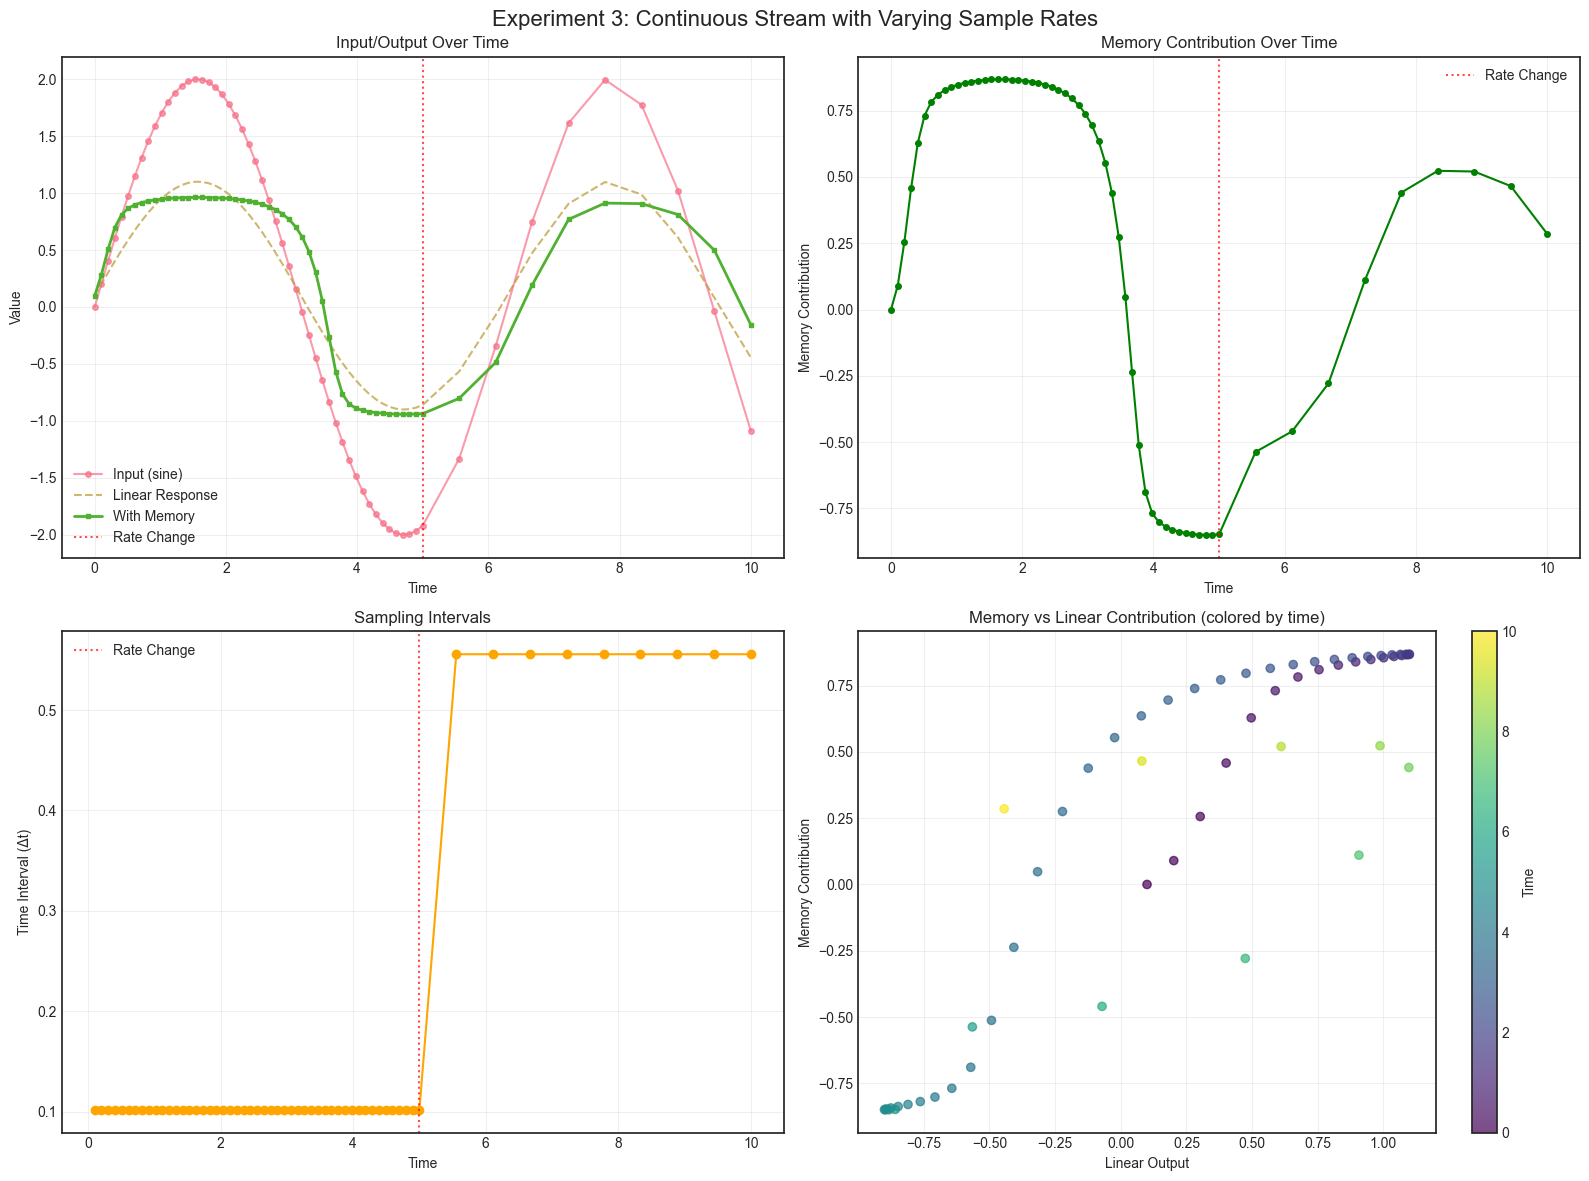


Summary:
Total time points: 59
Dense phase (0-5s): 50 points
Sparse phase (5-10s): 9 points
Average time diff in dense phase: 0.102
Average time diff in sparse phase: 0.556


In [11]:
def experiment_continuous_stream():
    neuron.reset_state()
    
    # Generate sine wave input with varying time steps
    total_time = 10.0
    
    # Create time points with varying density
    # Dense sampling in first half, sparse in second half
    t1 = np.linspace(0, total_time/2, 50)  # Dense: 50 points in 5 seconds
    t2 = np.linspace(total_time/2, total_time, 10)  # Sparse: 10 points in 5 seconds
    times = np.concatenate([t1, t2[1:]])  # Remove duplicate point
    
    # Generate sine wave inputs
    inputs = np.sin(times) * 2.0  # Amplitude = 2
    
    results = []
    
    for i, (t, inp) in enumerate(zip(times, inputs)):
        with torch.no_grad():
            x = torch.tensor(inp, dtype=torch.float32)  # Fix dtype
            
            # Calculate components
            linear_out = inp * neuron.weight.item() + neuron.bias.item()
            
            if neuron.initialized:
                time_diff = t - neuron.prev_timestamp.item()
                decay = np.exp(-time_diff)
                memory_contrib = neuron.alpha * neuron.prev_values.item() * decay
            else:
                decay = 0.0
                memory_contrib = 0.0
                time_diff = 0.0
            
            output = neuron(x, torch.tensor(t, dtype=torch.float32))  # Fix dtype
            
            results.append({
                'time': t,
                'input': inp,
                'linear_out': linear_out,
                'memory_contrib': memory_contrib,
                'final_output': output.item(),
                'decay_factor': decay,
                'time_diff': time_diff
            })
    
    return results, times

results3, times = experiment_continuous_stream()

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Experiment 3: Continuous Stream with Varying Sample Rates', fontsize=16)

times_list = [r['time'] for r in results3]
inputs = [r['input'] for r in results3]
outputs = [r['final_output'] for r in results3]
linear_outs = [r['linear_out'] for r in results3]
memory_contribs = [r['memory_contrib'] for r in results3]
time_diffs = [r['time_diff'] for r in results3]

# Plot 1: Input and Output vs Time
axes[0,0].plot(times_list, inputs, 'o-', alpha=0.7, label='Input (sine)', markersize=4)
axes[0,0].plot(times_list, linear_outs, '--', alpha=0.7, label='Linear Response')
axes[0,0].plot(times_list, outputs, 's-', label='With Memory', linewidth=2, markersize=3)
axes[0,0].axvline(x=5.0, color='red', linestyle=':', alpha=0.7, label='Rate Change')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Value')
axes[0,0].set_title('Input/Output Over Time')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Memory Contribution
axes[0,1].plot(times_list, memory_contribs, 'o-', color='green', markersize=4)
axes[0,1].axvline(x=5.0, color='red', linestyle=':', alpha=0.7, label='Rate Change')
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('Memory Contribution')
axes[0,1].set_title('Memory Contribution Over Time')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Time Intervals
axes[1,0].plot(times_list[1:], time_diffs[1:], 'o-', color='orange', markersize=6)
axes[1,0].axvline(x=5.0, color='red', linestyle=':', alpha=0.7, label='Rate Change')
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('Time Interval (Δt)')
axes[1,0].set_title('Sampling Intervals')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Memory vs Linear Contribution
axes[1,1].scatter(linear_outs, memory_contribs, c=times_list, cmap='viridis', alpha=0.7)
cbar = plt.colorbar(axes[1,1].collections[0], ax=axes[1,1])
cbar.set_label('Time')
axes[1,1].set_xlabel('Linear Output')
axes[1,1].set_ylabel('Memory Contribution')
axes[1,1].set_title('Memory vs Linear Contribution (colored by time)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSummary:")
print(f"Total time points: {len(results3)}")
print(f"Dense phase (0-5s): {sum(1 for r in results3 if r['time'] <= 5.0)} points")
print(f"Sparse phase (5-10s): {sum(1 for r in results3 if r['time'] > 5.0)} points")
print(f"Average time diff in dense phase: {np.mean([r['time_diff'] for r in results3 if r['time'] <= 5.0 and r['time_diff'] > 0]):.3f}")
print(f"Average time diff in sparse phase: {np.mean([r['time_diff'] for r in results3 if r['time'] > 5.0]):.3f}")

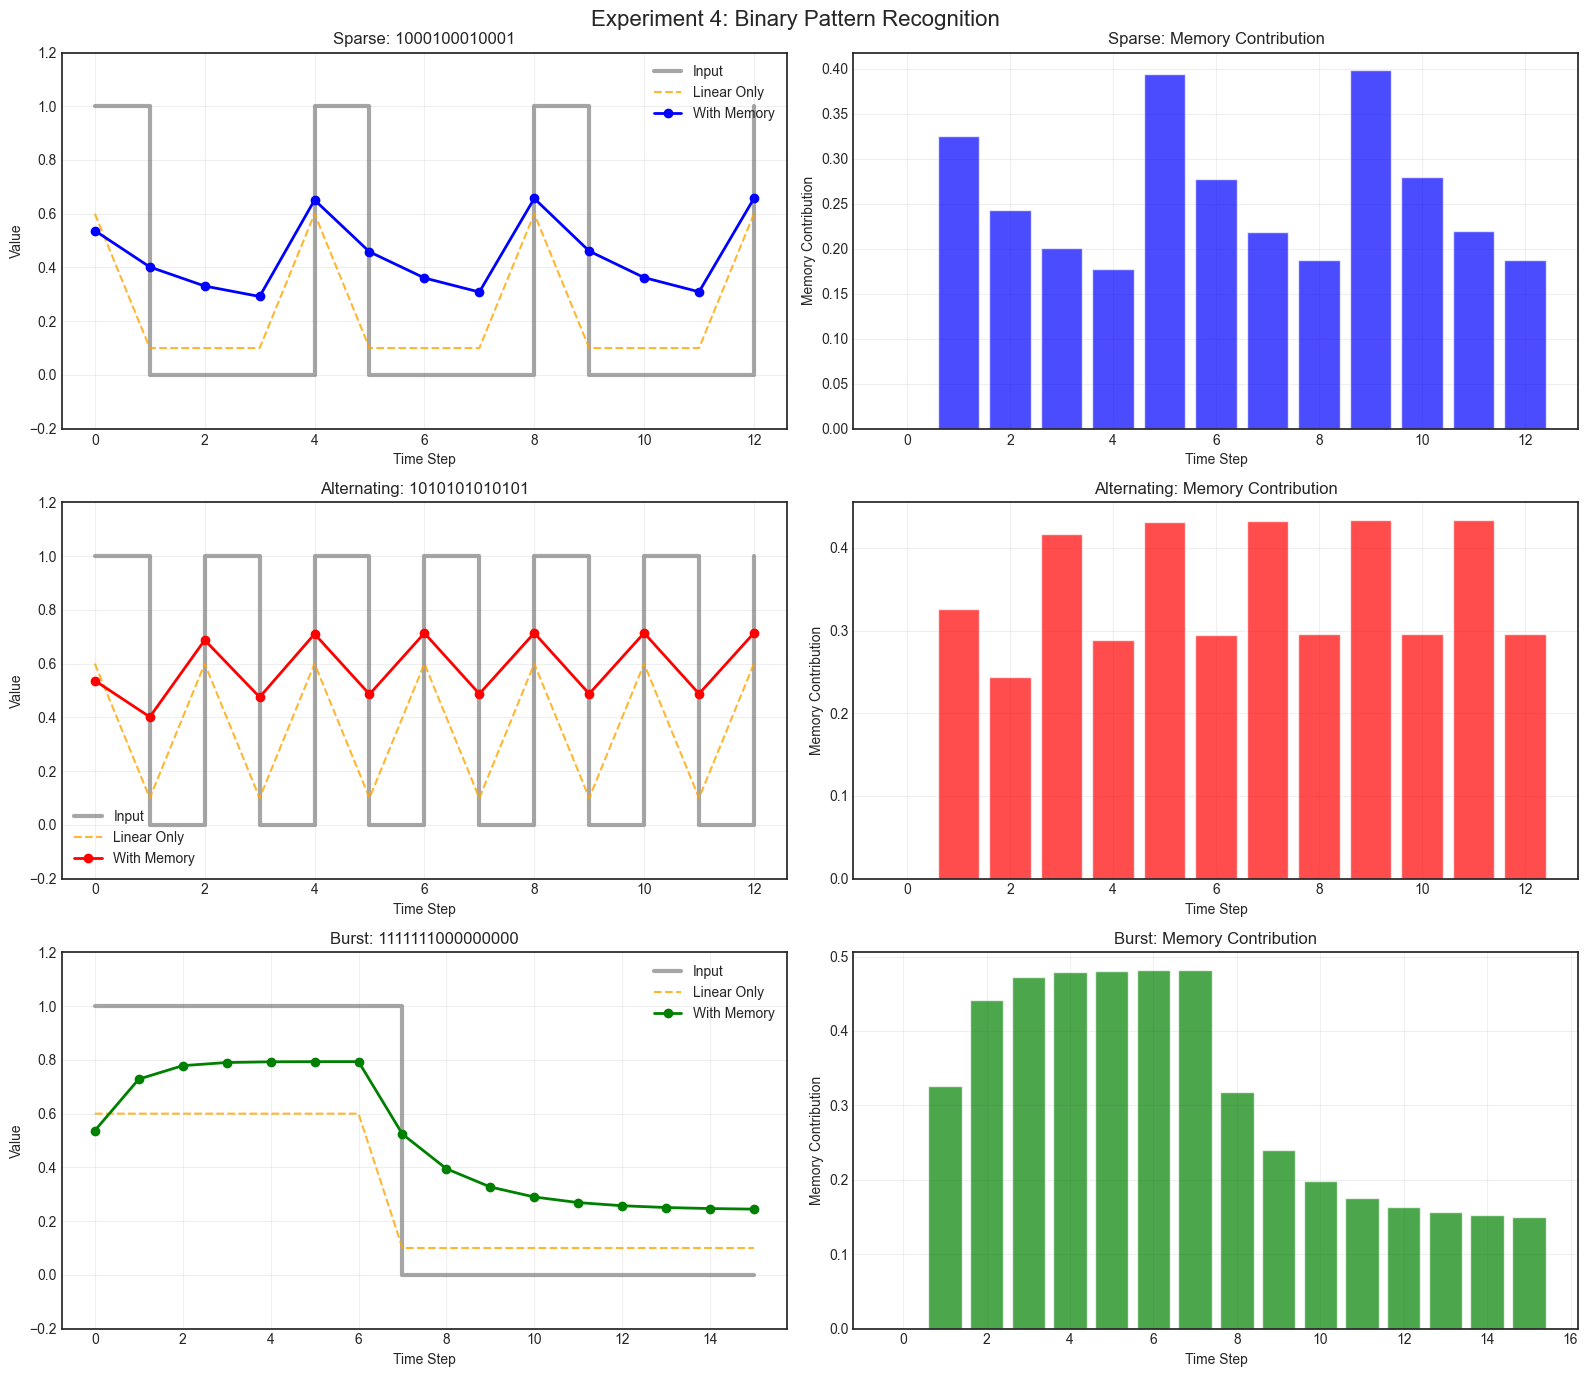

\nDetailed Pattern Analysis:
\nSparse Pattern: 1000100010001
----------------------------------------
Step\tInput\tLinear\tMemory\tFinal\tDecay
----------------------------------------
   0\t  1.0\t 0.600\t 0.000\t 0.537\t0.000
   1\t  0.0\t 0.100\t 0.326\t 0.402\t0.607
   2\t  0.0\t 0.100\t 0.244\t 0.331\t0.607
   3\t  0.0\t 0.100\t 0.201\t 0.292\t0.607
   4\t  1.0\t 0.600\t 0.177\t 0.651\t0.607
   5\t  0.0\t 0.100\t 0.395\t 0.458\t0.607
   6\t  0.0\t 0.100\t 0.278\t 0.361\t0.607
   7\t  0.0\t 0.100\t 0.219\t 0.308\t0.607
   8\t  1.0\t 0.600\t 0.187\t 0.657\t0.607
   9\t  0.0\t 0.100\t 0.398\t 0.461\t0.607
  10\t  0.0\t 0.100\t 0.279\t 0.362\t0.607
  11\t  0.0\t 0.100\t 0.220\t 0.309\t0.607
  12\t  1.0\t 0.600\t 0.188\t 0.657\t0.607
\nAlternating Pattern: 1010101010101
----------------------------------------
Step\tInput\tLinear\tMemory\tFinal\tDecay
----------------------------------------
   0\t  1.0\t 0.600\t 0.000\t 0.537\t0.000
   1\t  0.0\t 0.100\t 0.326\t 0.402\t0.607
   2\t  1

In [12]:
def experiment_binary_patterns():
    """Test how neuron responds to different binary input patterns."""
    
    patterns = {
        'Sparse': '1000100010001',      # Sparse pulses
        'Alternating': '1010101010101',  # Regular alternating 
        'Burst': '1111111000000000'      # Burst then silence
    }
    
    time_step = 0.5  # Fixed time interval
    
    results = {}
    
    for pattern_name, pattern in patterns.items():
        neuron.reset_state()
        pattern_results = []
        current_time = 0.0
        
        for i, bit in enumerate(pattern):
            current_time += time_step
            input_val = float(bit)  # Convert '0'/'1' to 0.0/1.0
            
            with torch.no_grad():
                x = torch.tensor(input_val, dtype=torch.float32)
                
                # Calculate components before forward pass
                linear_out = input_val * neuron.weight.item() + neuron.bias.item()
                
                if neuron.initialized:
                    time_diff = current_time - neuron.prev_timestamp.item()
                    decay = np.exp(-time_diff)
                    memory_contrib = neuron.alpha * neuron.prev_values.item() * decay
                else:
                    decay = 0.0
                    memory_contrib = 0.0
                
                # Get final output
                output = neuron(x, torch.tensor(current_time, dtype=torch.float32))
                
                pattern_results.append({
                    'step': i,
                    'time': current_time,
                    'input': input_val,
                    'linear_out': linear_out,
                    'memory_contrib': memory_contrib,
                    'final_output': output.item(),
                    'decay_factor': decay
                })
        
        results[pattern_name] = pattern_results
    
    return results, patterns

# Run the experiment
results4, patterns = experiment_binary_patterns()

# Create visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle('Experiment 4: Binary Pattern Recognition', fontsize=16)

colors = ['blue', 'red', 'green']
pattern_names = list(patterns.keys())

for i, (pattern_name, pattern_data) in enumerate(results4.items()):
    # Extract data
    steps = [r['step'] for r in pattern_data]
    inputs = [r['input'] for r in pattern_data]
    outputs = [r['final_output'] for r in pattern_data]
    linear_outs = [r['linear_out'] for r in pattern_data]
    memory_contribs = [r['memory_contrib'] for r in pattern_data]
    
    color = colors[i]
    
    # Plot 1: Input vs Output comparison
    axes[i, 0].step(steps, inputs, where='post', label='Input', linewidth=3, alpha=0.7, color='gray')
    axes[i, 0].plot(steps, linear_outs, '--', label='Linear Only', alpha=0.8, color='orange')
    axes[i, 0].plot(steps, outputs, 'o-', label='With Memory', linewidth=2, color=color, markersize=6)
    axes[i, 0].set_title(f'{pattern_name}: {patterns[pattern_name]}')
    axes[i, 0].set_xlabel('Time Step')
    axes[i, 0].set_ylabel('Value')
    axes[i, 0].legend()
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].set_ylim(-0.2, 1.2)
    
    # Plot 2: Memory contribution
    axes[i, 1].bar(steps, memory_contribs, alpha=0.7, color=color)
    axes[i, 1].set_title(f'{pattern_name}: Memory Contribution')
    axes[i, 1].set_xlabel('Time Step')
    axes[i, 1].set_ylabel('Memory Contribution')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\\nDetailed Pattern Analysis:")
print("=" * 60)

for pattern_name, pattern_data in results4.items():
    print(f"\\n{pattern_name} Pattern: {patterns[pattern_name]}")
    print("-" * 40)
    print("Step\\tInput\\tLinear\\tMemory\\tFinal\\tDecay")
    print("-" * 40)
    
    for r in pattern_data:
        print(f"{r['step']:4d}\\t{r['input']:5.1f}\\t{r['linear_out']:6.3f}\\t{r['memory_contrib']:6.3f}\\t{r['final_output']:6.3f}\\t{r['decay_factor']:5.3f}")

# Summary statistics
print("\\n\\nPattern Summary:")
print("=" * 50)
for pattern_name, pattern_data in results4.items():
    outputs = [r['final_output'] for r in pattern_data]
    memory_contribs = [r['memory_contrib'] for r in pattern_data]
    
    print(f"\\n{pattern_name}:")
    print(f"  Output range: {min(outputs):.3f} to {max(outputs):.3f}")
    print(f"  Avg output: {np.mean(outputs):.3f}")
    print(f"  Max memory contribution: {max(memory_contribs):.3f}")
    print(f"  Avg memory contribution: {np.mean(memory_contribs):.3f}")

## Experiment 4: Binary Pattern Recognition

Simple demonstration with binary input patterns to show memory effects clearly.

### Key Insights from Binary Patterns

**Sparse Pattern (1000100010001)**: 
- Memory decays between pulses, each '1' starts relatively fresh
- Output shows discrete spikes with minimal carry-over

**Alternating Pattern (1010101010101)**:
- Consistent memory contribution builds up over time
- '0' inputs still produce output due to memory from previous '1'
- Creates smooth oscillating behavior

**Burst Pattern (1111111000000000)**:
- Memory accumulates during burst phase (first 7 steps)
- Strong memory effects during silence phase (steps 8-16)
- Shows how temporal context influences current response

## Key Insights

### Experiment 1: Different Inputs
- **Linear component**: Directly proportional to input (weight × input + bias)
- **Memory component**: Depends on previous output and temporal decay
- **Combined effect**: Memory can amplify or dampen current response

### Experiment 2: Timing Effects
- **Short intervals** (Δt < 1): Strong memory influence, high decay factor
- **Long intervals** (Δt > 2): Weak memory influence, low decay factor
- **Exponential decay**: Memory influence drops exponentially with time

### Experiment 3: Real-world Behavior
- **Dense sampling**: Smooth temporal continuity, strong memory effects
- **Sparse sampling**: More "forgetful" behavior, closer to linear response
- **Adaptive response**: Network naturally adapts to input frequency